# <center>Acme Credit Reports: Risk Model for Rent Arrears</center>
# <center>Appendix</center>
## <center>July 2019</center>
### Fay Korkontzelou

<br>  
**Appedix notebook should be run first as it cleans the file that is used in the main report**

__Appendix A__
1. payment_amount
2. dob
3. payment_date
4. debt
5. Demographic Statistics
6. References

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [35]:
placeholder = './'
rental_data=pd.read_csv(placeholder + 'rental_data.csv',index_col=0, parse_dates=['paymentDate_clean','dob_clean'], \
               dtype={'houseID':'object','houseZip':'object'})

columns = 'name house_id house_zip rent_amount payment_date dob payment_amount'
rental_data.columns = columns.split()

rental_data.head()
rental_data.shape
len(set(rental_data.name))
min(rental_data.groupby('name').nunique()['house_id'])
max(rental_data.groupby('name').nunique()['house_id'])
rental_data.payment_date.min()
rental_data.payment_date.max()

,name,house_id,house_zip,rent_amount,payment_date,dob,payment_amount
0,Paulina Lefort,1869,92129,1324.0,2010-01-02,NaT,1324.0
1,Clare Tilly,407,92155,1723.0,2010-01-02,NaT,1723.0
2,Eleni Loudin,647,92111,1494.0,2010-01-02,2000-01-01,1494.0
3,Tandy Ammann,2215,92153,1438.0,2010-01-02,1992-12-02,1438.0
4,Tamra Trisler,2213,92172,1658.0,2010-01-02,2000-01-01,1658.0


(56610, 7)

1989

1

5

Timestamp('2010-01-02 00:00:00')

Timestamp('2012-12-10 00:00:00')

__Summary of dataset "rental_data.csv:__  
* The dataset consists of 56,610 rental payment transactions and 7 columns of relevant information for each transaction
* The dataset contains information on 1,989 individuals, who have rented between 1 to 5 different properties
* The dataset contains rental payment transactions for the period 2010 to 2012  
  
Next, we look for missing values in the dataset.

name                  0
house_id              0
house_zip             0
rent_amount           0
payment_date          0
dob               14725
payment_amount      528
dtype: int64

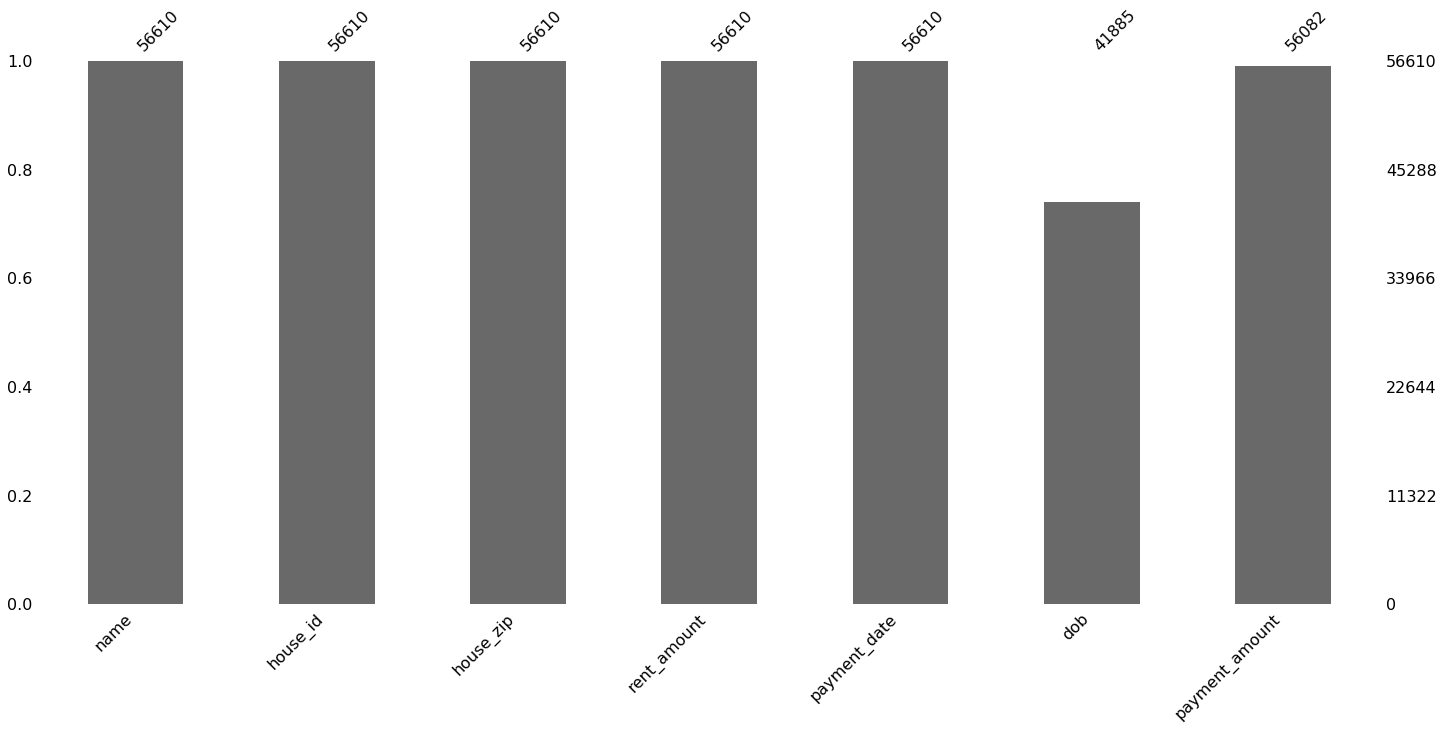

In [36]:
import missingno as msno

rental_data.isnull().sum()
msno.bar(rental_data)

There columns 'dob' and 'payment_amount' have 26% and 1% blank values respectively. All other columns are fully populated. Decisions on how to handle missing data will depend on the specific feature and will be explored in more detail below. A null value can be interpreted as either a missing value, due to error in data entry or absence of information, or as a 0 value.

In the sections that follow, we explore the features of the dataset that we believe require further cleansing and assumptions to be made for their interpretation. Through a careful exploration of data, we will make the assumptions we consider more fit for purpose and make the according transformations in a copy of the original dataset. We will be then ready to proceed with investigating the risk among tenants.  
We will use two methods to do so. Firstly, we will look at the newly cleansed dataset for predicting risk. Secondly, we will look at the dataset where we remove all records that are not clean. We will make a conclusion then on the predictive accuracy between the model based on what we think is more costly, a lesser clean dataset based on several assumptions or the loss of data.

In [37]:
# start by creating a copy of original dataset for further data cleansing
rental_data_clean = rental_data.copy()

__A.1 payment_amount__

In [38]:
print('Number of values equal to zero:', len(rental_data[rental_data['payment_amount']==0]))
print('Number of blank values:', rental_data['payment_amount'].isnull().sum())
print('Number of values where payment_amount equals the rent_amount:', \
      len(rental_data[rental_data['payment_amount']==rental_data['rent_amount']]))
print('Number of values where payment_amount exceeds the rent_amount:', \
      len(rental_data[rental_data['payment_amount']>rental_data['rent_amount']]))
print('Number of values where payment_amount is less than the rent_amount:', \
      len(rental_data[rental_data['payment_amount']<rental_data['rent_amount']]))
print('Number of negative values:', len(rental_data[rental_data['payment_amount']<0]))
print('\n')
print('Check that all cases are captured: 528 + 49527 + 5997 + 558 =', str(528+49527+5997+558))

Number of values equal to zero: 0
Number of blank values: 528
Number of values where payment_amount equals the rent_amount: 49527
Number of values where payment_amount exceeds the rent_amount: 5997
Number of values where payment_amount is less than the rent_amount: 558
Number of negative values: 558


Check that all cases are captured: 528 + 49527 + 5997 + 558 = 56610


All rent payments that are less than the rent due and are not blank are entered as negative values. The consistency of this practice across the dataset forbids the interpretation of this as bad data and its removal as this would leave us with a dataset where no tenant pays less than the amount due. In order to make a decision on how to handle negative values in 'payment_amount', we need to examine these transactions more closely.

max (in absolute value) negative payments: -348.0
min (in absolute value) negative payments: -101.25
mean of negative payments: -224.23548387096773 ; median of negative payments: -224.1
standard deviation of negative payments: 46.14999684330257


(array([  7.,  26.,  50.,  90., 101., 118.,  86.,  47.,  26.,   7.]),
 array([-348.   , -323.325, -298.65 , -273.975, -249.3  , -224.625,
        -199.95 , -175.275, -150.6  , -125.925, -101.25 ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Distribution for negative payments')

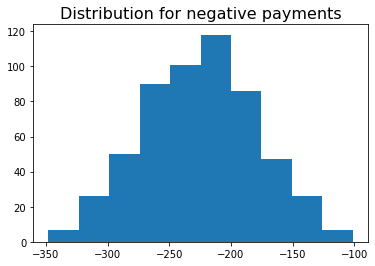

In [39]:
# look at the distribution of negative payments
payments_neg = [i for i in list(rental_data['payment_amount']) if i < 0]

print('max (in absolute value) negative payments:', min(payments_neg))
print('min (in absolute value) negative payments:', max(payments_neg))
print('mean of negative payments:', np.mean(payments_neg), '; median of negative payments:', np.median(payments_neg))
print('standard deviation of negative payments:', np.std(payments_neg))

plt.hist(payments_neg)
plt.title('Distribution for negative payments', fontsize=16)

In [40]:
min(rental_data['rent_amount'])
(rental_data.loc[rental_data['payment_amount']<rental_data['rent_amount'],'payment_amount'] > 0).sum()

428.0

0

All negative values in 'payment_amount' are between -101.25 and -348. Looking at the bell-shaped histogram, the negative values we observe are highly centrered around the mean $\approx$ median $\approx$ -224.  
We can now say with confidence that negative amounts of rent payment represent only under-payments since the lowest rent amount due ($428) is greater in absolute value than any of the negative payment amount values, and also all payments that are lower than the rent due are negative values.

<Figure size 1080x360 with 0 Axes>

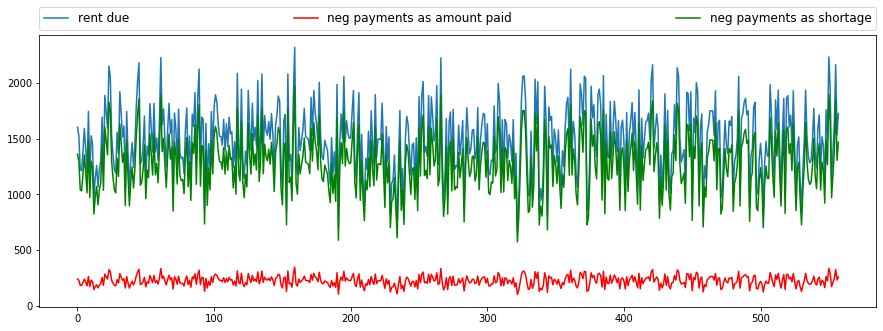

In [41]:
rent_due = list(rental_data.loc[rental_data['payment_amount'] < 0, 'rent_amount'])
payments_abs = [abs(x) for x in payments_neg]
payments_short = [y+x for y,x in zip(rent_due,payments_neg)]

plt.figure(figsize=(15,5))
plt.plot(rent_due, label='rent due')
plt.plot(payments_abs, 'r', label='neg payments as amount paid')
plt.plot(payments_short, 'g', label='neg payments as shortage')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0., fontsize = 'large')

plt.show()

As illustrated in the above graph, there are two ways to interpret the negative data in 'payment_amount'; either as the actual amount paid (red line) or the shortage in the amount paid from the rent due, in which case the amount paid is given by the green line.

Overall for 'payment_amount' we have the below.  
  
__Issues Identified:__  
* There are 528 missing values for the payment amount
* There are 5997 instances where the payment amount exceeds the rent amount
* There are 558 instances where the the tenant has made a payment smaller than the rent amount, and that amount is a negative value  
  
__Assumptions:__  
* Since there are no values in 'payment_amount' that equal zero, we assume that a blank entry represent that no payment was made. We will hence replace of null values in 'payment_amount' with zero.
* We assume that in the cases where the payment amount exceeds the monthly rent due, the tenant is trying to repay an existing debt, and hence the debt is reduced by that surplus in the payment
* There are two ways to interpret the negative values in 'payment_amount'; either as the shortage from the rent amount that is due or as the amount that was actually paid in which case the minus sign is an error in the data. Based on the above analysis, we decide to go with the first case and hence we will transform all negative values be taking the sum of the shortage and respective rent due to derive the amount that was paid. We are able to make this assumption only due to the consistency in the way the negative values are entered. Having said that, this assumption about data entry is made only for the case where less, but not null, rent was paid. We are not saying that where the correct rent amount is paid, the value in 'payment_amount' should be 0 or that positive payment amounts should be interpreted as the suplus on top of the rent due.

In [42]:
# replace missing values with 0
rental_data_clean.payment_amount.fillna(0, inplace=True)

# replace negative values with sum of rent amount and shortage
rental_data_clean['payment_amount'] = np.where(rental_data_clean['payment_amount']<0,
                                               rental_data_clean['rent_amount'] + rental_data_clean['payment_amount'],
                                               rental_data_clean['payment_amount'])

In [43]:
#check
rental_data.iloc[194]['payment_amount']
rental_data_clean.iloc[194]['payment_amount']

rental_data.iloc[36]['rent_amount']
rental_data.iloc[36]['payment_amount']
rental_data_clean.iloc[36]['payment_amount']

nan

0.0

1603.0

-240.45

1362.55

__A.2 dob__  

Date of births in the dataset are from 1900 to 2068
After 1900 year, the earlier dob year in the data is 1939:


dob      1939-05-10 00:00:00
name                       1
dob_y                   1939
dtype: object

Number of occurances with missing dob: 14725


Text(0.5, 0.98, 'dob distribution')

<BarContainer object of 473 artists>

<BarContainer object of 473 artists>

(0, 3)

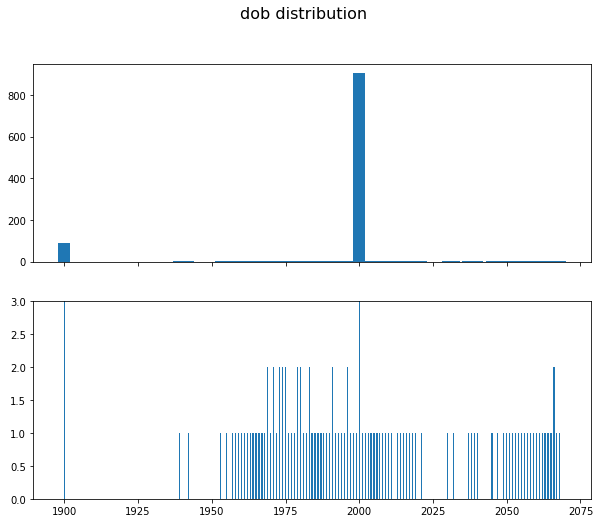

In [44]:
# group by 'dob' to see how many people in the dataset have the same birthday
dob = rental_data.groupby('dob').nunique()[['name']].reset_index()
# only look at year of birthday
dob['dob_y'] = pd.to_datetime(dob['dob']).dt.year
print('Date of births in the dataset are from', min(dob['dob_y']), 'to', max(dob['dob_y'])) 
print('After 1900 year, the earlier dob year in the data is 1939:')
dob[dob['dob_y']!=1900].min()
print('Number of occurances with missing dob:', rental_data['dob'].isnull().sum())

# set year of 'dob' as index and remove blanks in order to visualise 
dob = dob.set_index('dob_y').dropna()

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.suptitle('dob distribution', fontsize=16)

ax1.bar(x=dob.index,height=dob['name'],width=4)

ax2.bar(x=dob.index, height=dob['name'], width=0.4)
ax2.set_ylim([0,3])


In [45]:
dob.loc[[1900,2000]]
dob.loc[[1939,1953]]
dob.loc[[2019,2030]]

,dob,name
dob_y,,
1900,1900-01-01,88
2000,2000-01-01,903
2000,2000-01-06,1
2000,2000-10-06,1
2000,2000-11-11,1


,dob,name
dob_y,,
1939,1939-05-10,1
1939,1939-06-08,1
1953,1953-11-04,1


,dob,name
dob_y,,
2019,2019-06-10,1
2030,2030-05-12,1


__Observations:__  
* There are two very large spikes in the number of tenants that have their birthday on the same day, namely, on the 01/01/1900 and the 01/01/2000. Other than that, 1-2 people have the same birthday.
* There is a gap in 'dob' between 1900 and 1939
* There is a gap in 'dob' between 1939 and 1953
* There is a gap in 'dob' between 2019 and 2030  
  
__Issues Identified:__  
  

Date of births for tenants in the time period 2010-2012 are from 1900 to 2068 which a clear indication of presence of incorrect entries. More specifically:
* Large amount of tenants with 'dob' in 01/01/1900 and 01/01/2000. Neither of these dates of birth are likely as the tenant would have been 110 and 10 years old respectively in 2010.
* For several tenants the date of birth is after 2012, which is clearly an error
* For several tenants the date of birth is less than 18 years before 2010
* There are 14725 rows in the dataset where the dob is missing  
  
__Assumptions:__
* Birth dates in 1900 will be considered an error and will be replaced with null. When a date is entered in the wrong format in excel, for example just one number is entered, excel changes the date to a date in 1900. Following the same logic, we assume this is an error in data entry and dob will be assumed unknown, thus null.
* We assume that a reasonable age range for tenants to be paying rent is 18-90 years old from the date of their first payment. For example, if a person has been paying rent since 2010, we will only accept dob between the years 1930-1992.
* For dates of birth that are after the accepted period there are two cases. Firstly. dates that are after 2030, will be considered a typing error and will be changed to 1930 and so on. Secondly, the remaining dates that are not accepted in the above mentioned period, will be assumed uknown and replaced with null.

In [46]:
from datetime import datetime, date
# In terms of dob we are interested in the year of birth not day so we can replace with just the year
rental_data_clean['dob'] = pd.DatetimeIndex(rental_data_clean['dob']).year
rental_data_clean.head()

,name,house_id,house_zip,rent_amount,payment_date,dob,payment_amount
0,Paulina Lefort,1869,92129,1324.0,2010-01-02,NaN,1324.0
1,Clare Tilly,407,92155,1723.0,2010-01-02,NaN,1723.0
2,Eleni Loudin,647,92111,1494.0,2010-01-02,2000.0,1494.0
3,Tandy Ammann,2215,92153,1438.0,2010-01-02,1992.0,1438.0
4,Tamra Trisler,2213,92172,1658.0,2010-01-02,2000.0,1658.0


In [47]:
t = rental_data.groupby('name').agg({'dob': 'min', 'payment_date': 'min'})

print('dob in 1900:', len(t.loc[t['dob'].dt.year == 1900]))
print('dob after rent records time period:', len(t.loc[t['dob'].dt.year > 2012]))
print('number of tenants younger than 18:', 
      len(t.loc[((t['payment_date'].dt.year - t['dob'].dt.year)<18) & (t['dob'].dt.year<=2012)]))
print('\n')
print('number of tenantes who first payed rent in 2010:', len(t.loc[t['payment_date'].dt.year == 2010]))
print('number of tenantes who first payed rent in 2011:', len(t.loc[t['payment_date'].dt.year == 2011]))
print('number of tenantes who first payed rent in 2012:', len(t.loc[t['payment_date'].dt.year == 2012]))

dob in 1900: 88
dob after rent records time period: 101
number of tenants younger than 18: 975


number of tenantes who first payed rent in 2010: 1876
number of tenantes who first payed rent in 2011: 58
number of tenantes who first payed rent in 2012: 55


In [48]:
# replace all birthdays in 1900 with null
rental_data_clean.loc[rental_data_clean.dob == 1900, 'dob'] = np.nan

# changes dates that are after 2030 to 1930 and so on
rental_data_clean['dob'] = np.where(rental_data_clean['dob'] >= 2030, rental_data_clean['dob']-100, rental_data_clean['dob'])

# replace all birthdays that would render a tenant outside the eligible age group with null (includes those with 'negative' age)
under_18 = list(rental_data_clean.loc[(rental_data_clean['payment_date'].dt.year - rental_data_clean['dob'])<18, 'name'])
rental_data_clean['dob'] = np.where(rental_data_clean['name'].isin(under_18), np.nan, rental_data_clean['dob'])

Date of births are between 1930  and  1994. All other dates assumed unknown.


<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'dob distribution cleaned')

<BarContainer object of 55 artists>

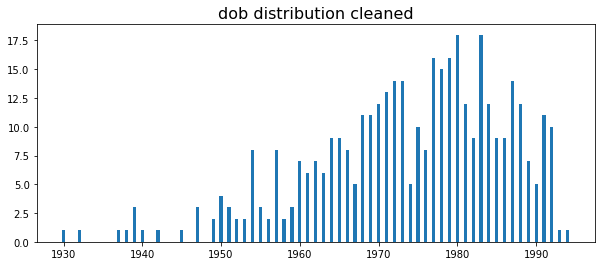

In [49]:
dob_clean = rental_data_clean.groupby('dob').nunique()[['name']].reset_index()
dob_clean = dob_clean.set_index('dob').dropna()

print('Date of births are between ' + str(int(rental_data_clean['dob'].min())), ' and ', \
      str(int(rental_data_clean['dob'].max())) + '. All other dates assumed unknown.')

plt.figure(figsize=(10,4))
plt.title('dob distribution cleaned', fontsize=16)
plt.bar(x=dob_clean.index,height=dob_clean['name'],width=0.4)

__A.3 payment_date__

In [50]:
rental_data['payment_date'].describe()
rental_data[['payment_date']].dtypes

count                   56610
unique                    997
top       2011-01-01 00:00:00
freq                     1232
first     2010-01-02 00:00:00
last      2012-12-10 00:00:00
Name: payment_date, dtype: object

payment_date    datetime64[ns]
dtype: object

In [51]:
rental_data['payment_year'] = pd.DatetimeIndex(rental_data['payment_date']).year
rental_data['payment_month'] = pd.DatetimeIndex(rental_data['payment_date']).month
rental_data.head()

,name,house_id,house_zip,rent_amount,payment_date,dob,payment_amount,payment_year,payment_month
0,Paulina Lefort,1869,92129,1324.0,2010-01-02,NaT,1324.0,2010,1
1,Clare Tilly,407,92155,1723.0,2010-01-02,NaT,1723.0,2010,1
2,Eleni Loudin,647,92111,1494.0,2010-01-02,2000-01-01,1494.0,2010,1
3,Tandy Ammann,2215,92153,1438.0,2010-01-02,1992-12-02,1438.0,2010,1
4,Tamra Trisler,2213,92172,1658.0,2010-01-02,2000-01-01,1658.0,2010,1


From the above table we see that dates appear to be in the format yyyy-mm-dd.

In [52]:
payment_per_month = rental_data.groupby(['name', 'house_id', 'payment_year', 'payment_month']).count()[['payment_date']]
print('The maximum number of payments per tenant per house per month is', payment_per_month['payment_date'].max())
print('The mean across the dataset is', round(np.mean(payment_per_month['payment_date']),2), 
      'and the median is', np.median(payment_per_month['payment_date']))

The maximum number of payments per tenant per house per month is 12
The mean across the dataset is 2.67 and the median is 1.0


<Figure size 720x288 with 0 Axes>

(array([16511.,   885.,   280.,   110.,   131.,   240.,   562.,   712.,
          672.,  1121.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

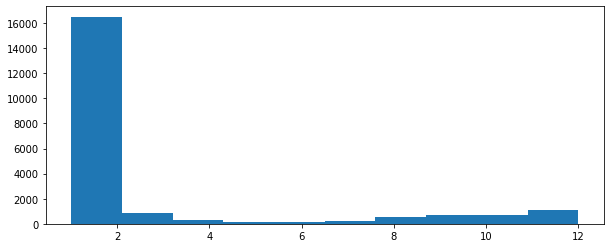

In [53]:
plt.figure(figsize=(10,4))
plt.hist(payment_per_month['payment_date'].values)

In [54]:
for i in range(1, 13):
    print(i, 'payments per month:', len(payment_per_month.loc[payment_per_month['payment_date'] == i]))

1 payments per month: 13449
2 payments per month: 3062
3 payments per month: 885
4 payments per month: 280
5 payments per month: 110
6 payments per month: 131
7 payments per month: 240
8 payments per month: 562
9 payments per month: 712
10 payments per month: 672
11 payments per month: 830
12 payments per month: 291


The issue with 'payment_date' appears to be that some dates have been inputted as in YDM date format and some in YMD format. Consequently, in the the histogram above, some tenants appear to be making 12 payments per month, whereas it is highly likely that they made 1 payment per month, on the same day of the month, for 12 consequtive months.
Before we are able to continue with analysis we need to ensure that dates are in consistent format across the dataset. More specifically, we need to decide on which basis we will decide where 'payment_date' has been entered in YDM format instead of YMD, and whether this behavious is consistent across just 'name', 'name' & "house_id', etc.

In [55]:
payment_per_month

payment_date
name           house_id payment_year payment_month              
Aaron Huston   1        2010         2                         1
                                     3                         1
                                     4                         1
                                     5                         1
                                     6                         1
                                     7                         1
                                     8                         1
                                     10                        1
                                     11                        1
                                     12                        1
                        2011         1                         1
                                     2                         1
                                     3                         1
                                     4                         1
                                     5                         1
                                     6                         1
                                     7                         1
                                     8                         1
                                     9                         1
                                     10                        1
                                     11                        1
                                     12                        1
                        2012         1                         1
                                     2                         1
                                     3                         1
                                     4                         1
                                     5                         1
                                     6                         1
                                     7                         1
                                     8                         1
...                                                          ...
Zofia Bilodeau 2468     2011         10                        1
                        2012         1                         3
                                     2                         2
                                     3                         1
                                     6                         1
                                     8                         1
Zofia Knoles   2469     2010         1                         3
               2470     2010         1                         8
                        2011         1                        12
                        2012         1                         9
Zoila Buth     2471     2010         1                        11
                        2011         1                        10
                        2012         1                         5
Zoila Faler    2472     2010         1                        10
                        2011         1                        11
                        2012         1                         8
                                     2                         1
Zola Howley    2473     2010         1                         8
                                     2                         2
                        2011         1                         1
                                     2                         1
               2474     2011         1                        10
                        2012         1                         8
Zona Thorton   2475     2010         1                         9
                                     2                         1
                                     3                         1
                        2011         1                         8
                                     2                         2
                        2012         1                         8
                      

The df 'payment_per_month' above helps us with understanding the rent payment behaviour of different tenants, and helps decide on the criterion for date format. For example, Aaron Huston has one payment for each month which indicates the date is inputted as YMD and read correctly. On the other hand, Zoila Buth has 11, 10 and 5 payments in January of 2010, 2011 and 2012 respectively. This is strong evidence that there an error in the date format here, and hence we take a closer look to get some insight.

In [56]:
rental_data.loc[rental_data.name == 'Zoila Buth'][['payment_year', 'payment_date']].pivot(columns ='payment_year')

payment_date                      
payment_year         2010       2011       2012
570            2010-01-02        NaT        NaT
1812           2010-01-03        NaT        NaT
2908           2010-01-04        NaT        NaT
4057           2010-01-05        NaT        NaT
4558           2010-01-06        NaT        NaT
5744           2010-01-07        NaT        NaT
7409           2010-01-08        NaT        NaT
8041           2010-01-09        NaT        NaT
9598           2010-01-10        NaT        NaT
10026          2010-01-11        NaT        NaT
11592          2010-01-12        NaT        NaT
20365                 NaT 2011-01-01        NaT
21470                 NaT 2011-01-02        NaT
21956                 NaT 2011-01-03        NaT
23887                 NaT 2011-01-04        NaT
24319                 NaT 2011-01-05        NaT
26731                 NaT 2011-01-07        NaT
28153                 NaT 2011-01-08        NaT
29052                 NaT 2011-01-09        NaT
29970                 NaT 2011-01-10        NaT
32223                 NaT 2011-01-12        NaT
41044                 NaT        NaT 2012-01-01
42121                 NaT        NaT 2012-01-02
43501                 NaT        NaT 2012-01-03
44828                 NaT        NaT 2012-01-04
45819                 NaT        NaT 2012-01-05

From looking, at the data, for Zoila Buth, one can easily infer that Zoila has been paying her rent on the first of each month and not on the first 12 days of January per year. Next, we choose to look at an example of a tenant that has paid rent on different properties in order to understand whether the differences in data entry depend solely on the tenants' name or the property as well. We look at Zola Howley and the house_id's 2473, 2474.

In [57]:
rental_data.loc[(rental_data.name == 'Zola Howley') & 
                (rental_data.house_id == '2473')][['payment_year', 'payment_date']].pivot(columns ='payment_year')
rental_data.loc[(rental_data.name == 'Zola Howley') & 
                (rental_data.house_id == '2474')][['payment_year', 'payment_date']].pivot(columns ='payment_year')

payment_date           
payment_year         2010       2011
1513           2010-01-03        NaT
2750           2010-01-04        NaT
5215           2010-01-06        NaT
6462           2010-01-07        NaT
6790           2010-01-08        NaT
8304           2010-01-09        NaT
9487           2010-01-10        NaT
11995          2010-01-12        NaT
12376          2010-02-02        NaT
12715          2010-02-05        NaT
20198                 NaT 2011-01-01
33301                 NaT 2011-02-02

payment_date           
payment_year         2011       2012
21809          2011-01-03        NaT
23799          2011-01-04        NaT
24641          2011-01-05        NaT
26113          2011-01-06        NaT
26996          2011-01-07        NaT
28025          2011-01-08        NaT
28984          2011-01-09        NaT
30739          2011-01-10        NaT
31100          2011-01-11        NaT
32922          2011-01-12        NaT
41266                 NaT 2012-01-01
42785                 NaT 2012-01-02
44272                 NaT 2012-01-03
44369                 NaT 2012-01-04
46548                 NaT 2012-01-05
46684                 NaT 2012-01-06
48431                 NaT 2012-01-07
48990                 NaT 2012-01-08

From the pivot table above, Zola Howley rent payments are recorded in YDM format for both the properties she rented in the period 2010-2012. Hence, it seems that the 'payment_date' date format is dependent on the tenant's name only.
Zola Howley has 8 recorded rent payments in January 2010, and only two in February. The next task is to understand the cases where there are more than one payments per month but still a small number across all months. For this, we look at the case of Zofia Bilodeau, who in 2012 has 1 payment per month in most months, 2 payment in one month and 3 in one month.

In [58]:
rental_data.loc[rental_data.name == 'Zofia Bilodeau'][['payment_year', 'payment_date']].pivot(columns ='payment_year')

payment_date                      
payment_year         2010       2011       2012
13256          2010-02-11        NaT        NaT
13730          2010-03-04        NaT        NaT
13918          2010-03-07        NaT        NaT
14005          2010-03-09        NaT        NaT
15850          2010-06-02        NaT        NaT
15863          2010-06-03        NaT        NaT
16064          2010-06-08        NaT        NaT
16239          2010-06-12        NaT        NaT
17350          2010-08-10        NaT        NaT
17705          2010-09-05        NaT        NaT
18694          2010-11-06        NaT        NaT
29130                 NaT 2011-01-09        NaT
31704                 NaT 2011-01-11        NaT
33590                 NaT 2011-02-04        NaT
33877                 NaT 2011-02-07        NaT
34566                 NaT 2011-03-01        NaT
35163                 NaT 2011-03-10        NaT
35223                 NaT 2011-03-12        NaT
35591                 NaT 2011-04-03        NaT
36496                 NaT 2011-05-05        NaT
37727                 NaT 2011-07-02        NaT
39124                 NaT 2011-09-06        NaT
39758                 NaT 2011-10-08        NaT
45376                 NaT        NaT 2012-01-04
47075                 NaT        NaT 2012-01-06
49506                 NaT        NaT 2012-01-08
51677                 NaT        NaT 2012-02-05
51960                 NaT        NaT 2012-02-09
52607                 NaT        NaT 2012-03-07
54203                 NaT        NaT 2012-06-01
55383                 NaT        NaT 2012-08-03

It is safe to assume from the above table that Zofia Bilodeau rent payments are recorded in YDM format. If we look at the payments made in 2012, assuming a YMD date format would mean she made 3 payments in January, 2 payments in February and then one payment in March , June and August, which is not reasonable. However, we can see that if we look at the payment dates in YDM format she made a payments withing the first days of the month from January to September with the exception of February.

In [71]:
rental_data['payment_day'] = pd.DatetimeIndex(rental_data['payment_date']).day
max_payment_per_month = payment_per_month.groupby('name')[['payment_date']].max()
max_payment_per_month.head()

,payment_date
name,
Aaron Huston,1
Abbey Kluth,3
Abe Prophet,11
Abel Emmett,12
Abraham Maggi,3


__Assumptions:__  
* Based on close examination of the cases where there are more than one payments per month, we assume that 'payment_date' dates are in YMD format when the maximum number of monthly rent payments is equal to 1 unless the day of payment is larger than 12. In all other cases, date will be assumed to be in YDM format and will be transformed to YMD.

In [64]:
print(len(max_payment_per_month), 'tenant names in dataset')
print('Of those, payment_date is in YMD date format for', 
      len(max_payment_per_month.loc[max_payment_per_month.payment_date == 1]))

1989 tenant names in dataset
Of those, payment_date is in YMD date format for 167


In [65]:
# create a list of names of those assumed to have 'payment_date' in YDM date format and need to be transformed to YMD format
names_to_change = list(max_payment_per_month.loc[max_payment_per_month.payment_date > 1].index.values) 

In [66]:
# in the new column payment_date_clean we change the payment date for tenants with more than one payment per month 
# and day of payment smaller or equal to 12
rental_data_clean['payment_date_clean'] = \
    rental_data_clean.loc[(rental_data_clean['name'].isin(names_to_change)) & (rental_data_clean['payment_date'].dt.day <=12)]\
    ['payment_date'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%d-%m')))

# we change the payment date for tenants with day of payment smaller or equal to 12
# rental_data_clean['payment_date_clean'] = \
# rental_data_clean.loc[rental_data_clean['payment_date'].dt.day <=12 ]['payment_date'].\
# apply(lambda x: pd.to_datetime(x.strftime('%Y-%d-%m')))

# for all other tenants we keep the original dates in the dataset from the payment_date column
rental_data_clean.payment_date_clean.fillna(rental_data_clean.payment_date, inplace=True)

In [67]:
# check example
names_to_change[1]
rental_data.loc[rental_data['name'].isin([names_to_change[1]])][['payment_date']].head()
rental_data_clean.loc[rental_data_clean['name'].isin([names_to_change[1]])][['payment_date_clean']].\
    sort_values(by=['payment_date_clean']).head()

'Abe Prophet'

,payment_date
296,2010-01-02
1755,2010-01-03
3032,2010-01-04
4041,2010-01-05
4400,2010-01-06


,payment_date_clean
296,2010-02-01
1755,2010-03-01
3032,2010-04-01
4041,2010-05-01
4400,2010-06-01


In [68]:
# check example of Abraham Maggi who has max_day 14
rental_data_clean.loc[rental_data_clean['name']=='Abraham Maggi'][['payment_date']].head(11)
rental_data_clean.loc[rental_data_clean['name']=='Abraham Maggi'][['payment_date_clean']].\
    sort_values(by=['payment_date_clean']).head(11)

,payment_date
1963,2010-01-03
12727,2010-02-06
12881,2010-02-07
13050,2010-02-09
14069,2010-03-10
14531,2010-04-04
15282,2010-05-05
16235,2010-06-12
18119,2010-10-02
18287,2010-10-08


,payment_date_clean
18119,2010-02-10
1963,2010-03-01
14531,2010-04-04
15282,2010-05-05
12727,2010-06-02
12881,2010-07-02
18287,2010-08-10
13050,2010-09-02
14069,2010-10-03
18845,2010-11-14


Looking above at the first five recorder rent payments for Abe Prophet we can see that the dates for 'payment_date' have been successully transformed to YMD format, and instead of showing 5 consecutive payments in January 2010, we are now showing 5 monthly payments on the first of each month, a much more reasonable result.  
In the case of Abraham Maggi, all dates have been transformed apart from 14/11/2011 which has been kept as in the original 'payment_date' column.

Following the data cleansing in sections A.1 - A.3, the new cleaned dataset is saved to "rental_data_clean.csv" which will be used throughout the main body of the report.

In [69]:
export_csv = rental_data_clean.to_csv(placeholder + 'rental_data_clean.csv')

__A.4 debt__

In [70]:
# The name of the columns 'debt' might be misleading. It is the difference between total rent due and total rent paid. 
# It is a debt only in the cases where the number is negative
debt = rental_data_clean.groupby(['name', 'house_id']).sum()[['rent_amount','payment_amount']]
debt['debt'] = debt['payment_amount'] - debt['rent_amount']
print('max surplus:', debt.debt.max())
print('max debt owed:', debt.debt.min())
print('debt median:', debt.debt.median())
print('\n')
print('Number of tenants with no debt:', len(debt[debt['debt']==0]))
print('Number of tenants with debt:', len(debt[debt['debt']<0]))
print('Number of tenants with surplus:', len(debt[debt['debt']>0]))
debt.head()

max surplus: 9899.0
max debt owed: -5865.300000000003
debt median: 0.0


Number of tenants with no debt: 1176
Number of tenants with debt: 712
Number of tenants with surplus: 582


,,rent_amount,payment_amount,debt
name,house_id,,,
Aaron Huston,1,53320.0,53320.00,0.00
Abbey Kluth,2,50189.0,57210.00,7021.00
Abe Prophet,4,34290.0,34118.55,-171.45
Abel Emmett,3,55862.0,55862.00,0.00
Abraham Maggi,5,38070.0,39204.00,1134.00


__Issues Identified:__  
* There are 582 instances where the tenant appears to have paid more than the rent was due  
  
__Assumptions:__
* There are a few reasons why this may be the case, and not an error. Firstly, the tenant might have to pay for damage in the property. Another occasion, which only applies for tenancies from the beginning of the dataset period, is that the tenant is trying to repay a debt which is not visible in the cutoff period contained in the dataset. As a general rule, and if we have no proof otherwise, we will assume that the tenant has no outstanding debt where the cumulative paid amount exceeds the cumulative rent amount due per tenant per property. 

__A.5 Demographic Statistics__

Demographic data has been downloaded from two websites to enhance the accuracy of the model. 



Sources of these demographics are the State of California main website and the San diago county. 


In [28]:
placeholder = './'
demographics1 = pd.read_csv(placeholder + 'demoforappendix.csv',index_col=0)
demographics1.head(7)

,Zip_code,Total population,Male,Female,Median age (years),Male Median age (years),Female Median age (years),Average Household size,Average Family size,Persons Under 5 years,Persons Under 18 years,Persons Age 21+,Persons Age 55+,Persons Age 60+,Persons Age 65+,Percent Population Female,Percent Population Less than 18,Unnamed: 18
Geography,,,,,,,,,,,,,,,,,,
California Total,NaN,"37,253,956","18,517,830","18,736,126",35.2,34.0,36.3,2.90,3.45,"2,531,333","9,295,040","26,228,272","8,283,007","6,078,711","4,246,514",50.3%,25.0%,NaN
ZCTA5 89010,89010.0,31,18,13,26.5,24.5,26.5,4.43,4.43,4,13,17,2,1,1,41.9%,41.9%,NaN
ZCTA5 89019,89019.0,69,39,30,38.3,38.5,38.0,2.88,3.93,8,18,49,17,11,6,43.5%,26.1%,NaN
ZCTA5 89060,89060.0,30,15,15,44.0,38.5,48.5,3.75,3.75,5,7,23,12,7,4,50.0%,23.3%,NaN
ZCTA5 89061,89061.0,51,23,28,47.5,40.5,50.0,2.43,2.92,2,13,38,19,16,13,54.9%,25.5%,NaN
ZCTA5 89439,89439.0,80,41,39,57.5,57.5,57.5,1.95,2.40,2,6,72,46,35,20,48.8%,7.5%,NaN
ZCTA5 90001,90001.0,"57,110","28,468","28,642",26.6,26.1,27.1,4.40,4.53,"5,733","19,979","33,962","6,970","4,797","3,179",50.2%,35.0%,NaN


Dataset above displays the raw data set which reports the average family size used as additinal variable in the model.

In [29]:
placeholder = './'
demographics2 = pd.read_csv(placeholder + 'demographics_race.csv',index_col=0)
demographics2.head(7)

,Total population,White,Black or African American,American Indian and Alaska Native,Total Asian,Asian Indian,Chinese,Filipino,Japanese,Korean,Vietnamese,Other Asian,Total NHOPI,Native Hawaiian,Guamanian or Chamorro,Samoan,Other Pacific Islander,Some Other Race,Unnamed: 19
Geography,,,,,,,,,,,,,,,,,,,
California zip codes,"37,253,956","21,453,934","2,299,072","362,801","4,861,007","528,176","1,253,102","1,195,580","272,528","451,892","581,946","577,783","144,386","21,423","24,299","40,900","57,764","6,317,372","1,815,384"
ZCTA5 90650,"105,549","52,089","4,593","1,213","12,700",870,908,"5,581",260,"2,610",822,"1,649",431,62,55,173,141,"29,954","4,569"
ZCTA5 90011,"103,892","35,138","9,764","1,219",591,42,81,78,10,241,31,108,37,4,22,4,7,"52,759","4,384"
ZCTA5 91331,"103,689","46,024","3,462",913,"4,516",224,114,"2,527",259,190,177,"1,025",118,21,34,6,57,"44,477","4,179"
ZCTA5 90201,"101,279","51,581","1,047","1,037",657,46,66,233,30,102,57,123,69,11,19,39,0,"43,006","3,882"
ZCTA5 92335,"95,397","46,362","4,567","1,141","1,539",159,153,516,44,62,215,390,335,29,24,131,151,"37,156","4,297"
ZCTA5 90280,"94,396","47,645",890,878,732,95,50,223,39,176,11,138,99,21,15,44,19,"40,624","3,528"


Dataset above displays the raw data set which reports population races in the area of San Diego per zip code area.

Calculations and some exclusions on the data have been performed to bring the data in the right format. 

In the race breakdown dataset, people with mixed race have been excluded from the analysis.
This exclusion on average do not exceed the 4.63% of the population per each area but still constitutes a limitation in the analysis.

The Percentage of white used in analysis is calculated as the number of white people $/$ Total population

In [30]:
placeholder = './'
demographics3 = pd.read_csv(placeholder + 'demographics_families_in_Poverty.csv',index_col=0)
demographics3.head(7)

,Family households with income below poverty level
Geography,
Central Region,18%
Central San Diego,14%
Mid-City,20%
Southeastern San Diego,18%
East Region,11%
Alpine,6%
El Cajon,18%


Familiy households with income below poverty level reflects the percentage of total polulation (%) with income level below the federal poverty level (FPL). The FRL is a measure of income in the USA that reflects if the income level is below a alimit and whether this individual or family qualifies them for certain benefits. 

* The limitation of this dataset is that many areas in San Diego were merged and some other areas were not covered.

* For the zip codes that were not covered in the dataset we used the median as a proxy for the rest of them. 

__A.6 References__

1) Table 1 — Total population, median age, sex, age, household and family size, 2010, State of California, Department of Finance, viewed 11 July <http://www.dof.ca.gov/Reports/Demographic_Reports/Census_2010/>


2) Table 3c — Population by Race (Hispanic Origin exclusive) and Hispanic Origin, 2010, State of California, Department of Finance, viewed 11 July <http://www.dof.ca.gov/Reports/Demographic_Reports/Census_2010/>


3) 2016 San Diego County Demographics - Families in Poverty, 2016, San Diego County, viewed 11 July 
<https://data.sandiegocounty.gov/Demographics/2016-San-Diego-County-Demographics-Families-in-Pov/ayc4-bmye>